/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/5


Training...: 100%|██████████| 36306/36306 [32:29<00:00, 18.62it/s]


Train Loss: 0.36026043525398754, Train Accuracy: 0.8351939679287995


Testing...: 100%|██████████| 9077/9077 [02:33<00:00, 59.11it/s]


Test Loss: 0.3141002803876745, Test Accuracy: 0.861124882939459
Epoch 2/5


Training...: 100%|██████████| 36306/36306 [33:14<00:00, 18.20it/s]


Train Loss: 0.2982016594375628, Train Accuracy: 0.8679158884135687


Testing...: 100%|██████████| 9077/9077 [02:33<00:00, 59.04it/s]


Test Loss: 0.29956893817296626, Test Accuracy: 0.8702831487908335
Epoch 3/5


Training...: 100%|██████████| 36306/36306 [32:44<00:00, 18.48it/s]


Train Loss: 0.2761985036736738, Train Accuracy: 0.8789350915397791


Testing...: 100%|██████████| 9077/9077 [02:29<00:00, 60.58it/s]


Test Loss: 0.29018885547054507, Test Accuracy: 0.8739808847022531
Epoch 4/5


Training...: 100%|██████████| 36306/36306 [32:33<00:00, 18.58it/s]


Train Loss: 0.2621177564475171, Train Accuracy: 0.8863426264643353


Testing...: 100%|██████████| 9077/9077 [02:29<00:00, 60.67it/s]


Test Loss: 0.28562925597036154, Test Accuracy: 0.8783396683743734
Epoch 5/5


Training...: 100%|██████████| 36306/36306 [32:29<00:00, 18.62it/s]


Train Loss: 0.2521370776388935, Train Accuracy: 0.8915277287633737


Testing...: 100%|██████████| 9077/9077 [02:28<00:00, 61.07it/s]


Test Loss: 0.2824707519045717, Test Accuracy: 0.8787046218255936


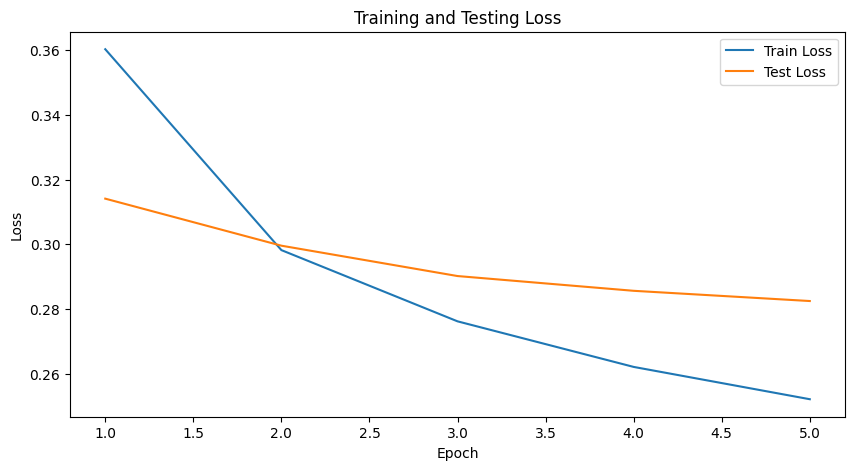

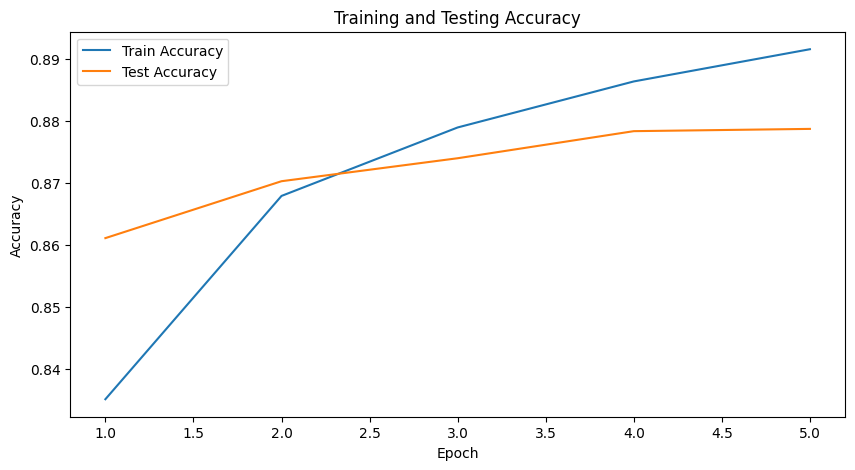

In [ ]:
#Run this cell to Test LstmNetwork
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt


class HateSpeechDataset(Dataset):
    def __init__(self, dataframe, vocab_to_int, max_length):
        self.data = dataframe
        self.vocab_to_int = vocab_to_int
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        Content = self.data.iloc[idx]['Content']
        label = self.data.iloc[idx]['Label']
        encode = [self.vocab_to_int[seq] for seq in Content.split() if seq in self.vocab_to_int]
        if len(encode) < self.max_length:
            encode += [0] * (self.max_length - len(encode))  #padding
        else:
            encode = encode[:self.max_length]

        seq_length = min(len(encode), self.max_length)

        return {
            'input_ids': torch.tensor(encode, dtype=torch.long),
            'length': torch.tensor(seq_length, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }



class Attention_layer(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention_layer, self).__init__()
        self.attention = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_output):
        output = self.attention(lstm_output)
        output = F.softmax(output, dim=1)
        output = torch.sum(output * lstm_output, dim=1)
        return output


class LSTMNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(LSTMNet, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.dropout_l = nn.Dropout(dropout)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True,dropout=0.1)

        self.attention = Attention_layer(hidden_dim)

        self.fc = nn.Linear(2*hidden_dim , output_dim)

    def forward(self, input_ids, lengths):
        output = self.embedding(input_ids)
        output = self.dropout_l(output)

        output = pack_padded_sequence(output, lengths.cpu(), batch_first=True, enforce_sorted=False)
        output,_  = self.lstm(output)
        output, _ = pad_packed_sequence(output, batch_first=True)

        output = self.attention(output)
        output = self.fc(output)
        return output


def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct_samples = 0
    n_sampels = 0

    for batch in tqdm(dataloader, desc="Training..."):
        input_ids = batch['input_ids'].to(device)
        lengths = batch['length'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, lengths)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        correct_samples += torch.sum(predicted == labels).item()
        n_sampels += labels.size(0)

    acc = correct_samples / n_sampels
    avg_train_loss = total_loss / len(dataloader)
    print(f"Train Loss: {avg_train_loss}, Train Accuracy: {acc}")
    return avg_train_loss, acc


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def test(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_samples = 0
    n_sampels = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Testing..."):
            input_ids = batch['input_ids'].to(device)
            lengths = batch['length'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_samples += torch.sum(predicted == labels).item()
            n_sampels += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    acc = correct_samples / n_sampels
    print(f"Test Loss: {avg_loss}, Test Accuracy: {acc}")
    return avg_loss, acc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = pd.read_csv("HateSpeechDatasetBalanced.csv")

train_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=30)
test_dataset = test_dataset.sample(n=6000, replace=False, random_state=30)


embedding_dim = 300
hidden_dim = 128
output_dim = 2
num_epochs = 5
batch_size = 16
learning_rate = 0.001


vocab_counter = Counter()
max_length = 500
for text in train_dataset['Content']:
    words = text.split()
    vocab_counter.update(words)

vocab_to_int = {word: i for i, (word, _) in enumerate(vocab_counter.items(), 1)}
vocab_size = len(vocab_to_int) + 1

train_dataset = HateSpeechDataset(train_dataset, vocab_to_int, max_length)
test_dataset = HateSpeechDataset(test_dataset, vocab_to_int, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


lstm_model = LSTMNet(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)


train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train(lstm_model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(lstm_model, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    torch.save(lstm_model.state_dict(), "LSTM_Hate_Speech_last.pth")


# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()
